# Business Context

Restaurant XYZ aims to understand its customers better and run its operations more efficiently in order to improve customer experience. As the data scientice consultant for them, my task will be to conduct analysis on the reviews of its customer, build a predictive model in order to classify which reviews are good, which reviews are bad and get an idea about the improvements that can be made

### 1. Importing modules, packages, and libraries
### 2. Data Collection
### 3. Data Exploration
### 4. Data preprocessing
### 5. Data Visualization
### 6. Feature Engineering
### 7. Models building
### 8. Final model selection
### 9. Conclusion

## 1. Importing libraries, packages, and modules

In [272]:
!pip install contractions
import re
import string
import contractions
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from google.colab import files
import pandas as pd
import textblob

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Data Collection

In [273]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]
filename
df = pd.read_csv(filename, delimiter = '\t')

Saving Restaurant_Reviews.tsv to Restaurant_Reviews (7).tsv


## 3. Data Exploration

In [274]:
df.shape

(1000, 2)

Our Dataset consists of 1000 rows and 2 columns, one column for the review and another column for the sentiment of the review

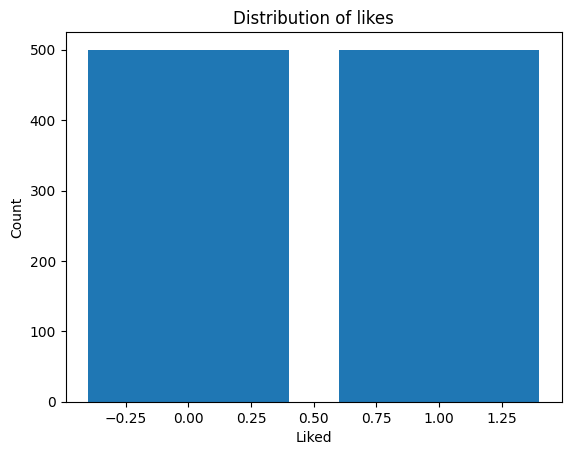

In [275]:
liked_counts = df['Liked'].value_counts()
plt.bar(liked_counts.index, liked_counts.values)
plt.xlabel('Liked')
plt.ylabel('Count')
plt.title('Distribution of likes')
plt.show()

As we see in the graph above, the dataset is balanced and has 500 positive reviews and 500 negative reviews. Since our dataset is balanced, the accuracy is a good measure of performance

## 4. Data preprocessing

In [276]:
# Define function for text cleaning
def clean_text(text):

    # Spell out contractions
    text = contractions.fix(text)

    tokens = sent_tokenize(text)

    tokens = [token for token in tokens if token]
    tokens = set(tokens)

    # Join the cleaned tokens back into a single string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Clean the 'reviews' column in the DataFrame
df['clean_reviews'] = df['Review'].apply(clean_text)

Here, we applied sentence tokenization as well as word tokenization. Overall, sentence teokenization had a better performance, thus we only kept the code of sentence tokenization here. In addition, extending contractions also had a positive impact on the accuracy.

## 5. Data Visualization

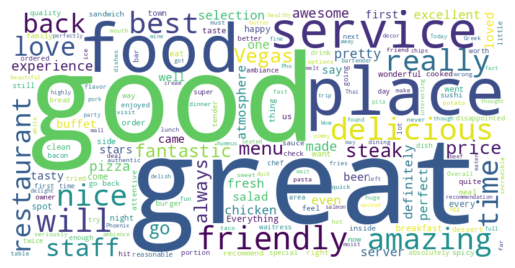

In [270]:
df_positive = df[df['Liked'] == 1]
# Combine all reviews into a single string
reviews_str = ' '.join(df_positive['clean_reviews'].values)

# Create a WordCloud object with the desired parameters
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200, contour_width=3, contour_color='steelblue')

# Generate the word cloud from the combined reviews string
wordcloud.generate(reviews_str)

# Plot the word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We see that the good reviews include mainly the words 'food', 'servie', 'good', 'place', which means the customers are liking the food, service and place

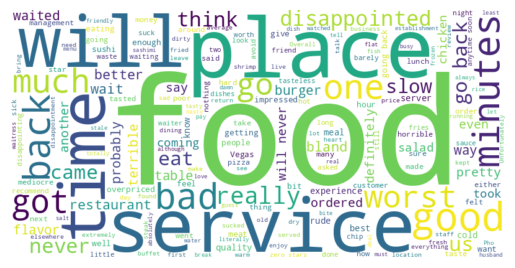

In [271]:
df_negative = df[df['Liked'] == 0]
# Combine all reviews into a single string
reviews_str = ' '.join(df_negative['clean_reviews'].values)

# Create a WordCloud object with the desired parameters
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200, contour_width=3, contour_color='steelblue')

# Generate the word cloud from the combined reviews string
wordcloud.generate(reviews_str)

# Plot the word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We see that some of the keywords in the bad reviews are ['time', 'slow']. This suggests that the resteaurant should work more on decreasing its waiting times by either hiring more staff, replacing slow workers, or replacing some of its equipment. We choose to focus on these terms as they carry the least amount of ambiguity, and the restaurant can easily use them to take action and improve

## 6. Feature Engineering

In [253]:
from textblob import TextBlob


polarity_scores=[]
subjectivity_scores=[]
for review in df['clean_reviews']:
    blob = TextBlob(review)
    polarity_scores.append(blob.sentiment.polarity)
    subjectivity_scores.append(blob.sentiment.subjectivity)

df['polarity'] = polarity_scores
df['subjectivity'] = subjectivity_scores

def normalize(feature):
  return (1 + feature) / 2

df['polarity'] = df['polarity'].apply(normalize)
X = df[['polarity','subjectivity']]
y = df['Liked']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 40)

In this step, we transform our features into two numeric vectors, polarity and positivity. We choose this transformation because it works well for text classification and is time efficient

## 7. Model Building

In [254]:
from sklearn.model_selection import cross_val_score
import numpy as np
tree_clf = DecisionTreeClassifier(criterion ='entropy', max_depth = 1)

search = tree_clf.fit(X_train, y_train)
best_scores = cross_val_score(search, X_train, y_train)
round(100 * np.mean(best_scores), 1)

79.2

In [255]:
logistic_model = LogisticRegression(max_iter=5000, C = 1)
logistic_model.fit(X_train, y_train)
best_scores = cross_val_score(logistic_model, X_train, y_train)
round(100 * np.mean(best_scores), 1)
#best_tree = search.best_estimator_


#print("Best accuracy: ", round(best_score * 100, 1),'%')
#print("Best Hyperparameters: ", best_params)
#print("Testing accuracy: {0:.1f}%".format(accuracy_score(y_train,y_pred)* 100))
#print("Classification report  \n %s" %(classification_report(y_train, y_pred)))

78.8

In [256]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB(var_smoothing = 1e-1)
classifier.fit(X_train, y_train)

best_scores = cross_val_score(classifier, X_train, y_train, cv=10)
round(100 * np.mean(best_scores), 1)



78.9

We run the decision tree model, logistic regression and naive bayes while experimenting with different hyperparameters and different preprocessing configurations. It turned out that the best model was the decision tree with 79.2% accuracy. That's why we will choose to make our predictions on the test set using decision trees

## 8. Final Model Selection

In [257]:
from sklearn.model_selection import cross_val_score
import numpy as np
tree_clf = DecisionTreeClassifier(criterion ='entropy', max_depth = 1)

#grid_search = GridSearchCV(estimator = tree_clf, param_grid = parameters, scoring = 'f1', cv= 10)
tree_clf.fit(X_train, y_train)
y_test_pred = tree_clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       146
           1       0.78      0.78      0.78       104

    accuracy                           0.82       250
   macro avg       0.81      0.81      0.81       250
weighted avg       0.82      0.82      0.82       250



## 9. Conclusion
We conclude that for this problem, sentence tokenization helped the machine learning models perform well. We used the polarity and subjectivity to transform our text into numeric values and this transformation led to a good performance and was time efficient. Decisiontree classifier performed the best with 82% accuracy and the test set and good values for recall precision and f1-score all above 75%. Our recommendation to the restaurant is to improve their waiting time, either by hiring more staff, buying new equipment or replacing slower workers.